# Lab 2: Image Classification using Feature Extraction and Machine Learning 
**Objective** :
The aim of this lab assignment is to classify images of dogs 
and cats using feature extraction techniques and machine 
learning classifiers. You will download the dataset, extract 
features using HOG and SURF, apply classification models, 
and compare their performances. 


Submitted By <br>
> Debatreya Das <br>
> 12212070 <br>
> CS

## Necessary Imports

In [5]:
# Install opencv-contrib-python if not already installed (uncomment if needed)
# !pip install opencv-contrib-python

import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Set a random seed for reproducibility
random.seed(42)
np.random.seed(42)

## Define Image Loading and Preprocessing Functions
Resize images to a fixed size (e.g. 128×128) so that the HOG (and even SIFT extraction) is consistent.

In [7]:
IMG_SIZE = (128, 128)  # width x height

def load_and_preprocess_image(path, img_size=IMG_SIZE):
    # Read in BGR (OpenCV default) and convert to grayscale
    img = cv2.imread(path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Resize image
    img = cv2.resize(img, img_size)
    return img


## Select 200 Cat and 200 Dog Images

In [9]:
# Define the dataset directory
data_dir = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages'

# Initialize lists to store file paths
cat_files = []
dog_files = []

# Iterate through the subdirectories (Cat and Dog)
for subdir in os.listdir(data_dir):
    subdir_path = os.path.join(data_dir, subdir)
    if os.path.isdir(subdir_path):  # Ensure it's a directory
        for filename in os.listdir(subdir_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')): #check for image files
                filepath = os.path.join(subdir_path, filename)
                if subdir.lower() == 'cat':
                    cat_files.append(filepath)
                elif subdir.lower() == 'dog':
                    dog_files.append(filepath)

# Randomly sample 200 images from each category
sample_size = 200
cat_files = random.sample(cat_files, min(sample_size, len(cat_files))) #sample only if available
dog_files = random.sample(dog_files, min(sample_size, len(dog_files))) #sample only if available


print(f"Number of cat images: {len(cat_files)}")
print(f"Number of dog images: {len(dog_files)}")

Number of cat images: 200
Number of dog images: 200


## Load the images and create labels
- Cats - 0
- Dogs - 1

In [10]:
images = []
labels = []

# Load cat images (label 0)
for f in tqdm(cat_files, desc="Loading cat images"):
    img = load_and_preprocess_image(os.path.join(data_dir, f))
    if img is not None:
        images.append(img)
        labels.append(0)

# Load dog images (label 1)
for f in tqdm(dog_files, desc="Loading dog images"):
    img = load_and_preprocess_image(os.path.join(data_dir, f))
    if img is not None:
        images.append(img)
        labels.append(1)

images = np.array(images)
labels = np.array(labels)
print(f"Total images loaded: {len(images)}")

Loading dog images: 100%|██████████| 200/200 [00:01<00:00, 122.89it/s]

Total images loaded: 399


seems like 1 image selected is corrupted

## Split into Training and Testing Sets
80/20 split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.20, random_state=42, stratify=labels
)

print(f"Training set: {X_train.shape[0]} images")
print(f"Testing set: {X_test.shape[0]} images")

Training set: 319 images
Testing set: 80 images


## Feature Extraction
extract features in two ways: HOG and SIFT (using a bag-of-words approach)

### HOG Feature Extraction

In [12]:
def extract_hog_features(image):
    # You can adjust the parameters as needed.
    features, hog_image = hog(
        image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True,
        feature_vector=True
    )
    return features

# Extract HOG features for training and testing sets
hog_features_train = [extract_hog_features(img) for img in tqdm(X_train, desc="Extracting HOG (train)")]
hog_features_test = [extract_hog_features(img) for img in tqdm(X_test, desc="Extracting HOG (test)")]

hog_features_train = np.array(hog_features_train)
hog_features_test = np.array(hog_features_test)

print("HOG feature shape (train):", hog_features_train.shape)

Extracting HOG (test): 100%|██████████| 80/80 [00:05<00:00, 14.23it/s]

HOG feature shape (train): (319, 8100)


### SIFT Feature Extraction via Bag-of-Words
Because SIFT produces a variable number of descriptors per image, we will:

1. Extract SIFT descriptors for each image.
2. Cluster all descriptors from the training set using KMeans (to form the “visual vocabulary”).
3. For each image, build a histogram of the visual word occurrences.

#### Extract SIFT Descriptors for a Single Image

In [13]:
# Create SIFT extractor (requires opencv-contrib-python)
sift = cv2.SIFT_create()

def extract_sift_descriptors(image):
    # image should be grayscale
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return descriptors

#### Collect SIFT Descriptors from All Training Images

In [14]:
all_descriptors = []

# We will also store each image’s descriptors in a list for later histogram computation.
sift_descriptors_train = []

for img in tqdm(X_train, desc="Extracting SIFT descriptors (train)"):
    des = extract_sift_descriptors(img)
    if des is not None:
        sift_descriptors_train.append(des)
        all_descriptors.append(des)
    else:
        sift_descriptors_train.append(np.array([]))  # empty array if no descriptors

# Stack all descriptors vertically
all_descriptors = np.vstack([des for des in all_descriptors if des is not None and len(des) > 0])
print("Total SIFT descriptors in training set:", all_descriptors.shape)

Extracting SIFT descriptors (train): 100%|██████████| 319/319 [00:02<00:00, 130.50it/s]

Total SIFT descriptors in training set: (41296, 128)


#### Build the Visual Vocabulary (Codebook) Using KMeans
clusters = 50

In [15]:
num_clusters = 50
kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=42, batch_size=1000)
kmeans.fit(all_descriptors)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(batch_size=1000, n_clusters=50, random_state=42)

#### Create a Function to Compute the SIFT Histogram for an Image

In [16]:
def compute_bow_histogram(descriptors, kmeans_model, num_clusters=num_clusters):
    # If no descriptors are found, return a zero histogram
    if descriptors is None or len(descriptors) == 0:
        return np.zeros(num_clusters)
    # Predict the closest cluster for each descriptor
    cluster_assignments = kmeans_model.predict(descriptors)
    hist, _ = np.histogram(cluster_assignments, bins=np.arange(num_clusters+1))
    # Optionally normalize the histogram
    hist = hist.astype("float")
    if hist.sum() != 0:
        hist /= hist.sum()
    return hist

#### Compute Bag-of-Words Histograms for Training and Testing Sets

In [17]:
# For training set
sift_features_train = []
for img, descriptors in zip(X_train, sift_descriptors_train):
    hist = compute_bow_histogram(descriptors, kmeans)
    sift_features_train.append(hist)
sift_features_train = np.array(sift_features_train)
print("SIFT (BoW) feature shape (train):", sift_features_train.shape)

SIFT (BoW) feature shape (train): (319, 50)


In [18]:
# For the test set, we need to extract SIFT descriptors first:
sift_features_test = []
for img in tqdm(X_test, desc="Extracting SIFT descriptors (test)"):
    des = extract_sift_descriptors(img)
    hist = compute_bow_histogram(des, kmeans)
    sift_features_test.append(hist)
sift_features_test = np.array(sift_features_test)
print("SIFT (BoW) feature shape (test):", sift_features_test.shape)

Extracting SIFT descriptors (test): 100%|██████████| 80/80 [00:00<00:00, 88.94it/s]

SIFT (BoW) feature shape (test): (80, 50)


## Classification with Epoch Tracking
Train two classifiers on each feature set. Because we want to plot accuracy vs. epoch, we use SGDClassifier with partial_fit which allows us to simulate training over several epochs.

Note:
- For Logistic Regression, we use loss='log'.
- For SVM, we use loss='hinge'.

### Define a Function for Epoch-wise Training and Evaluation

In [19]:
def train_with_epochs(X_train, y_train, X_test, y_test, loss, epochs=10):
    """
    Train an SGDClassifier with the specified loss over a given number of epochs.
    Returns the final classifier and a list of test accuracies at the end of each epoch.
    """
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize classifier. We set warm_start to True (or use partial_fit) to update the model.
    clf = SGDClassifier(loss=loss, max_iter=1, tol=None, random_state=42, learning_rate='optimal', shuffle=True)
    
    # For partial_fit we need to provide the list of classes.
    classes = np.unique(y_train)
    
    test_accuracies = []
    for epoch in range(epochs):
        # Use partial_fit to train on the whole training set once.
        clf.partial_fit(X_train_scaled, y_train, classes=classes)
        test_accuracy = clf.score(X_test_scaled, y_test)
        test_accuracies.append(test_accuracy)
        print(f"Epoch {epoch+1}/{epochs} - Test Accuracy: {test_accuracy:.4f}")
    return clf, test_accuracies, scaler

### Train on HOG Features

#### HOG + Logistic Regression

In [20]:
print("Training HOG + Logistic Regression")
hog_lr_clf, hog_lr_accuracies, hog_scaler = train_with_epochs(
    hog_features_train, y_train, hog_features_test, y_test, loss='log', epochs=10
)

Training HOG + Logistic Regression
Epoch 1/10 - Test Accuracy: 0.6875
Epoch 2/10 - Test Accuracy: 0.6875
Epoch 3/10 - Test Accuracy: 0.6250
Epoch 4/10 - Test Accuracy: 0.6625
Epoch 5/10 - Test Accuracy: 0.6375
Epoch 6/10 - Test Accuracy: 0.6375
Epoch 7/10 - Test Accuracy: 0.6375
Epoch 8/10 - Test Accuracy: 0.6375
Epoch 9/10 - Test Accuracy: 0.6375
Epoch 10/10 - Test Accuracy: 0.6375


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


#### HOG + SVM

In [21]:
print("Training HOG + SVM")
hog_svm_clf, hog_svm_accuracies, _ = train_with_epochs(
    hog_features_train, y_train, hog_features_test, y_test, loss='hinge', epochs=10
)

Training HOG + SVM
Epoch 1/10 - Test Accuracy: 0.6375
Epoch 2/10 - Test Accuracy: 0.6375
Epoch 3/10 - Test Accuracy: 0.6750
Epoch 4/10 - Test Accuracy: 0.6750
Epoch 5/10 - Test Accuracy: 0.7000
Epoch 6/10 - Test Accuracy: 0.7000
Epoch 7/10 - Test Accuracy: 0.7125
Epoch 8/10 - Test Accuracy: 0.7000
Epoch 9/10 - Test Accuracy: 0.7000
Epoch 10/10 - Test Accuracy: 0.7000


### Train on SIFT (Bag-of-Words) Features

#### SIFT + Logistic Regression

In [22]:
print("Training SIFT + Logistic Regression")
sift_lr_clf, sift_lr_accuracies, sift_scaler = train_with_epochs(
    sift_features_train, y_train, sift_features_test, y_test, loss='log', epochs=10
)

Training SIFT + Logistic Regression
Epoch 1/10 - Test Accuracy: 0.4875
Epoch 2/10 - Test Accuracy: 0.5625
Epoch 3/10 - Test Accuracy: 0.5625
Epoch 4/10 - Test Accuracy: 0.5875
Epoch 5/10 - Test Accuracy: 0.4750
Epoch 6/10 - Test Accuracy: 0.5250
Epoch 7/10 - Test Accuracy: 0.4750
Epoch 8/10 - Test Accuracy: 0.5000
Epoch 9/10 - Test Accuracy: 0.4500
Epoch 10/10 - Test Accuracy: 0.5000


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


#### SIFT + SVM

In [23]:
print("Training SIFT + SVM")
sift_svm_clf, sift_svm_accuracies, _ = train_with_epochs(
    sift_features_train, y_train, sift_features_test, y_test, loss='hinge', epochs=10
)

Training SIFT + SVM
Epoch 1/10 - Test Accuracy: 0.4750
Epoch 2/10 - Test Accuracy: 0.5000
Epoch 3/10 - Test Accuracy: 0.4500
Epoch 4/10 - Test Accuracy: 0.5625
Epoch 5/10 - Test Accuracy: 0.4250
Epoch 6/10 - Test Accuracy: 0.4250
Epoch 7/10 - Test Accuracy: 0.5500
Epoch 8/10 - Test Accuracy: 0.5250
Epoch 9/10 - Test Accuracy: 0.5000
Epoch 10/10 - Test Accuracy: 0.5625


## Performance Comparison

In [24]:
print("Final Test Accuracies:")
print(f"HOG + Logistic Regression: {hog_lr_accuracies[-1]:.4f}")
print(f"HOG + SVM: {hog_svm_accuracies[-1]:.4f}")
print(f"SIFT + Logistic Regression: {sift_lr_accuracies[-1]:.4f}")
print(f"SIFT + SVM: {sift_svm_accuracies[-1]:.4f}")

Final Test Accuracies:
HOG + Logistic Regression: 0.6375
HOG + SVM: 0.7000
SIFT + Logistic Regression: 0.5000
SIFT + SVM: 0.5625


## Feature Fusion & Classification
 concatenate the HOG and SIFT feature vectors (for each image) to form a combined feature vector, and then retrain the classifiers.

### Create Combined Feature Vectors

In [25]:
# Concatenate features along the feature dimension
fusion_features_train = np.hstack([hog_features_train, sift_features_train])
fusion_features_test = np.hstack([hog_features_test, sift_features_test])

print("Fusion feature shape (train):", fusion_features_train.shape)
print("Fusion feature shape (test):", fusion_features_test.shape)

Fusion feature shape (train): (319, 8150)
Fusion feature shape (test): (80, 8150)


### Train on Fused Features

#### Fusion + Logistic Regression

In [26]:
print("Training Fusion + Logistic Regression")
fusion_lr_clf, fusion_lr_accuracies, fusion_scaler = train_with_epochs(
    fusion_features_train, y_train, fusion_features_test, y_test, loss='log', epochs=10
)

Training Fusion + Logistic Regression
Epoch 1/10 - Test Accuracy: 0.6250
Epoch 2/10 - Test Accuracy: 0.6500
Epoch 3/10 - Test Accuracy: 0.6875
Epoch 4/10 - Test Accuracy: 0.6875
Epoch 5/10 - Test Accuracy: 0.6875
Epoch 6/10 - Test Accuracy: 0.6875
Epoch 7/10 - Test Accuracy: 0.6750
Epoch 8/10 - Test Accuracy: 0.6750
Epoch 9/10 - Test Accuracy: 0.6750
Epoch 10/10 - Test Accuracy: 0.6750


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


#### Fusion + SVM

In [29]:
print("Training Fusion + SVM")
fusion_svm_clf, fusion_svm_accuracies, _ = train_with_epochs(
    fusion_features_train, y_train, fusion_features_test, y_test, loss='hinge', epochs=10
)

Training Fusion + SVM
Epoch 1/10 - Test Accuracy: 0.6250
Epoch 2/10 - Test Accuracy: 0.7000
Epoch 3/10 - Test Accuracy: 0.6375
Epoch 4/10 - Test Accuracy: 0.6750
Epoch 5/10 - Test Accuracy: 0.6875
Epoch 6/10 - Test Accuracy: 0.6625
Epoch 7/10 - Test Accuracy: 0.6625
Epoch 8/10 - Test Accuracy: 0.6625
Epoch 9/10 - Test Accuracy: 0.6625
Epoch 10/10 - Test Accuracy: 0.6625


### Report Final Fusion Model Accuracies

In [30]:
print("Final Fusion Test Accuracies:")
print(f"Fusion + Logistic Regression: {fusion_lr_accuracies[-1]:.4f}")
print(f"Fusion + SVM: {fusion_svm_accuracies[-1]:.4f}")

Final Fusion Test Accuracies:
Fusion + Logistic Regression: 0.6750
Fusion + SVM: 0.6625


## Plot Epoch vs. Accuracy for Each Combination

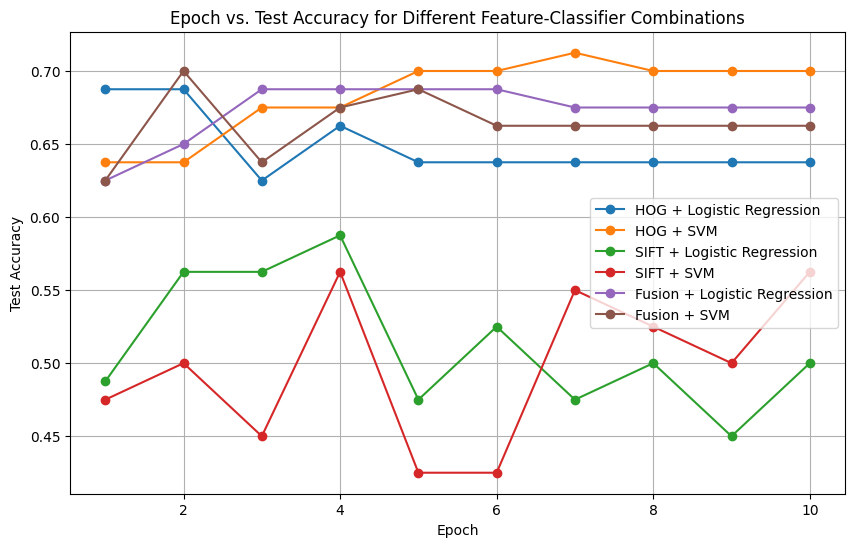

In [31]:
epochs = np.arange(1, 11)

plt.figure(figsize=(10, 6))
plt.plot(epochs, hog_lr_accuracies, marker='o', label='HOG + Logistic Regression')
plt.plot(epochs, hog_svm_accuracies, marker='o', label='HOG + SVM')
plt.plot(epochs, sift_lr_accuracies, marker='o', label='SIFT + Logistic Regression')
plt.plot(epochs, sift_svm_accuracies, marker='o', label='SIFT + SVM')
plt.plot(epochs, fusion_lr_accuracies, marker='o', label='Fusion + Logistic Regression')
plt.plot(epochs, fusion_svm_accuracies, marker='o', label='Fusion + SVM')
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Epoch vs. Test Accuracy for Different Feature-Classifier Combinations")
plt.legend()
plt.grid(True)
plt.show()